In this notebook target label is created using vader sentiment analyser

### Importing Libraries

In [21]:
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.types import FloatType
from pyspark.sql import Row
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Pyspark Mongo Db connection

In [23]:
spark = SparkSession \
.builder \
.appName("mongodbtest1") \
.master('local')\
.config("spark.mongodb.input.uri", "mongodb://localhost:27017/bdata.scored_reviews_updated") \
.config("spark.mongodb.output.uri", "mongodb://localhost:27017/bdata.scored_reviews_updated") \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
.getOrCreate()

23/04/10 21:01:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [24]:
reviews = spark.read\
.format('com.mongodb.spark.sql.DefaultSource')\
.option( "uri", "mongodb://localhost:27017/bdata.scored_reviews_updated") \
.load()

23/04/10 21:01:10 WARN MongoInferSchema: Field 'listing_id' contains conflicting types converting to StringType
23/04/10 21:01:10 WARN MongoInferSchema: Field 'reviewer_id' contains conflicting types converting to StringType


In [25]:
reviews.show(5), reviews.count()

+--------------------+--------+----------+-----------+-----+
|                 _id|compound|listing_id|reviewer_id|score|
+--------------------+--------+----------+-----------+-----+
|{64340868e800520d...|     0.0|   1178162|   20763927|    2|
|{64340868e800520d...|  0.8519|   1178162|   12717709|    4|
|{64340868e800520d...|  0.7841|   1178162|   33049657|    4|
|{64340868e800520d...|  0.6808|   1178162|   28249766|    4|
|{64340868e800520d...|  0.8732|   1178162|   40649244|    4|
+--------------------+--------+----------+-----------+-----+
only showing top 5 rows



(None, 7391)

In [26]:
# select column in loaded 
reviews1 = reviews.select(['listing_id', 'reviewer_id', 'score'])
# cast column datatype as float
reviews1 = reviews1.withColumn('listing_id', col('listing_id').cast(FloatType()))
reviews1 = reviews1.withColumn('reviewer_id', col('reviewer_id').cast(FloatType()))
reviews1 = reviews1.withColumn('score', col('score').cast(FloatType()))


# filter null values listing id
reviews1 = reviews1.where(reviews1.listing_id.isNotNull())

In [27]:
# get null value counts
reviews1.select([count(when(isnan(c), c)).alias(c) for c in reviews1.columns]).show()

+----------+-----------+-----+
|listing_id|reviewer_id|score|
+----------+-----------+-----+
|         0|          0|    0|
+----------+-----------+-----+



In [40]:
# # Count the number of ratings for each user
# user_counts = reviews1.groupBy("reviewer_id").agg(count("*").alias("count"))

# # Filter the users with more than 1 rating
# filtered_users = user_counts.filter("count > 1")

# # Get the user IDs as a list
# user_ids = filtered_users.select("reviewer_id").rdd.flatMap(lambda x: x).collect()

# reviews2 = reviews1.filter(col("reviewer_id").isin(user_ids))

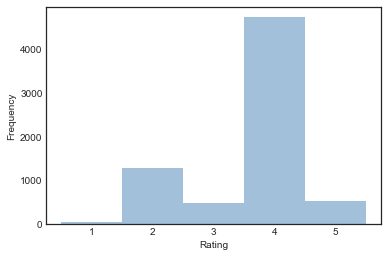

In [41]:
# visualise the distribution of rating score

reviews = reviews1.select('score').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [42]:
# split data
train_data, test_data = reviews1.randomSplit([0.8, 0.2], seed=0)


In [43]:
# get no of records in training data
train_data.count(), test_data.count()

(5655, 1446)

In [44]:
als = ALS(
    rank=20,
    maxIter=10, # updated parameters based on the hyperparameter values
    regParam=0.2,
    userCol="reviewer_id",
    itemCol="listing_id",
    ratingCol="score",
    coldStartStrategy="drop",implicitPrefs=False,
    nonnegative=True
)


evaluator = RegressionEvaluator(metricName="mae",
                            labelCol="score",
                            predictionCol="prediction")


In [45]:
# hyperparameter tuning of model
param_grid = ParamGridBuilder()\
    .addGrid(als.rank,[5,10,20,30])\
    .addGrid(als.regParam,[ 0.01, 0.1, 0.05,0.2])\
    .addGrid(als.maxIter,[10,20,30,40])\
    .build()


# cross validation on training data
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
# create model based on cv 
model = cv.fit(train_data)

best_rank = model.bestModel.rank
best_regparam = model.bestModel._java_obj.parent().getRegParam()
best_maxiter = model.bestModel._java_obj.parent().getMaxIter()
print(f'Rank : {best_rank}, Regparam: {best_regparam}, Maxiter: {best_maxiter}')

# Generate predictions on the test data
predictions = model.bestModel.transform(test_data)

mae = evaluator.evaluate(predictions)
print('Mae on Test set',mae)


In [45]:
# train model
model = als.fit(train_data)
# Generate predictions on the test data
train_predictions = model.transform(train_data)
train_mae = evaluator.evaluate(train_predictions)
print('mae on train set',train_mae)

predictions = model.transform(test_data)
mae = evaluator.evaluate(predictions)
print('mae on Test set',mae)


mae on train set 0.17688557019178894
mae on Test set 2.0647601259406656


In [46]:
# getting recommendations for all the users

from pyspark.sql.functions import col, explode, when

user_recs = model.recommendForAllUsers(10)

# Explode the recommendations column to get individual (item ID, rating) tuples
exploded_recs = user_recs.select("reviewer_id", \
                                 explode("recommendations")).select("reviewer_id", 
                                                                    col("col.listing_id"), 
                                                                    col("col.rating"))
# Clip the ratings to the 1 to 5 range
clipped_recs = exploded_recs.withColumn("rating", when(col("rating") < 1, 1).when(col("rating") > 5, 5).otherwise(col("rating")))

In [47]:
clipped_recs.show()#collect()[0]['recommendations']

+-----------+----------+---------+
|reviewer_id|listing_id|   rating|
+-----------+----------+---------+
|       5599|    210097| 3.786518|
|       5599|  13306811| 3.759314|
|       5599|   2395326|3.7557144|
|       5599|   1066767|3.6441634|
|       5599|   8536127|3.6085236|
|       5599|   5166870|3.5414672|
|       5599|   8563141|3.5268424|
|       5599|  10883063|3.3836446|
|       5599|   9841140| 3.271917|
|       5599|  12618291|3.2247663|
|       5811|   1885825|3.8186982|
|       5811|    197972|3.7432733|
|       5811|   1401625| 3.722004|
|       5811|   5295491|3.5335271|
|       5811|   3870046|3.3945508|
|       5811|   8450098|3.3565278|
|       5811|   4870883|3.3086288|
|       5811|   5074924|3.1683695|
|       5811|      5506|3.1438344|
|       5811|   9231486| 3.126635|
+-----------+----------+---------+
only showing top 20 rows



In [48]:
# Save data to a CSV file
clipped_recs.coalesce(1).write.format("csv").mode('overwrite').option("header", "true").save("../results/recommend")